In [192]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

In [202]:
iteration = 1
PhenoGraph_k =  100
size_smallest_cluster = 20
survival_type = 'Disease-specific'
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':15
}

In [203]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

In [204]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)
Community_ids = detect_communities(G_population, size_smallest_cluster)

In [205]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relpase-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{}:".format(HR[i]['subgroup_id']))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

S1:
Survival: hr = 1.7845111927334922, p = 0.029821531480932216
S2:
Survival: hr = 1.5729847682398042, p = 0.16876233030739657
S3:
Survival: hr = 1.511109345609021, p = 0.029855834218434317
S4:
Survival: hr = 1.2635359051406, p = 0.45789378258910596
S5:
Survival: hr = 1.2341530024404563, p = 0.44287262103501646
S6:
Survival: hr = 1.007816410622416, p = 0.9820029187799466
S7:
Survival: hr = 0.5959670974338167, p = 0.11560269991891632
S8:
Survival: hr = 0.5843077424062787, p = 0.0499875103901145
S9:
Survival: hr = 0.46644342958418916, p = 0.020440765944935674


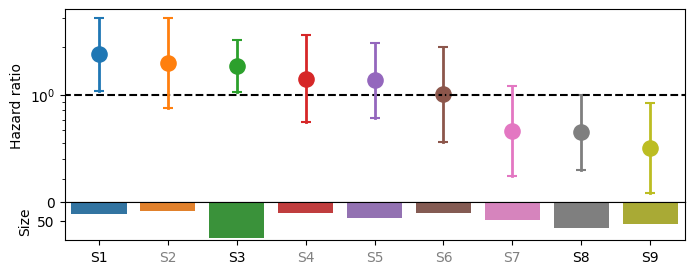

In [206]:
# Plot hazard ratio
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

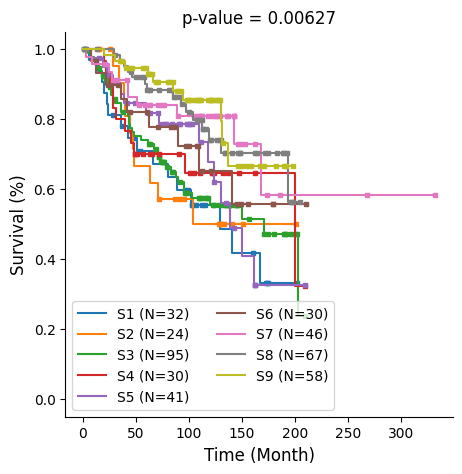

In [207]:

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

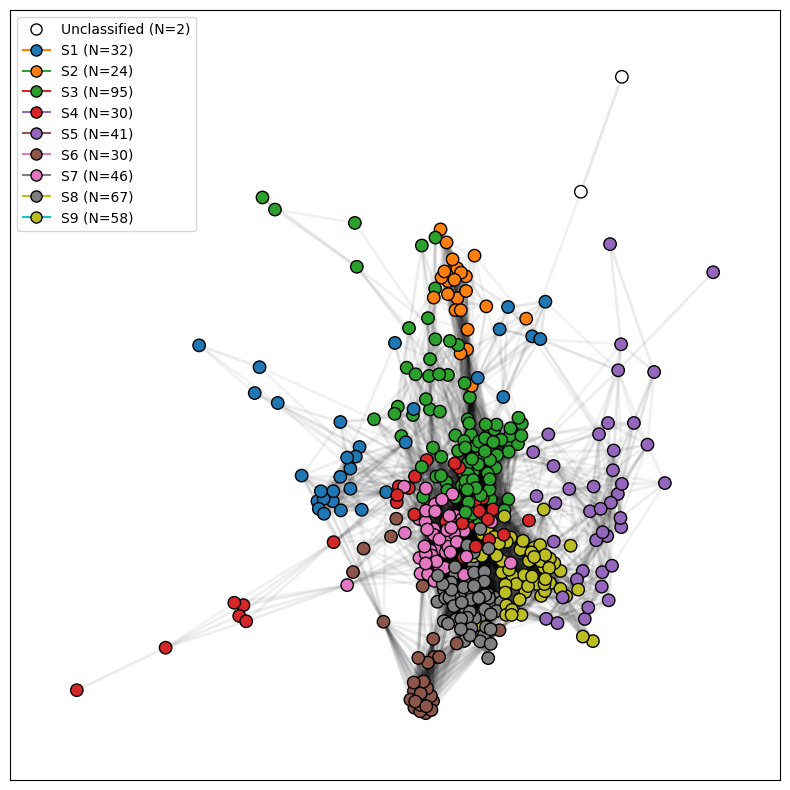

In [208]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

### Candidates for prognosis-relevant patterns: overpresented

In [209]:
Candidates = []
Candiates_overpresented_in_subgroup = []
from scipy import stats
for hr_dict in HR:
    subgroup_id = hr_dict["subgroup_id"]
    hr = hr_dict["hr"]
    p = hr_dict["p"]
    if p < 0.05:
        Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
        Histogram_out_group = Histograms_[Subgroup_ids_ != subgroup_id]
        for i in range(Histograms_.shape[1]):
            rvsi = Histogram_intra_group[:, i]
            rvso = Histogram_out_group[:, i]
            result = stats.ttest_ind(rvsi, rvso, equal_var=False)
            if result.pvalue < 0.05/Histograms_.shape[1]/len(HR):
                if np.median(rvsi) > np.median(rvso):
                    print(
                        "S{}: Feature {} is overpresented (p={:.5f})".format(
                            subgroup_id, i, result.pvalue
                        )
                    )
                    Candidates.append(i)
                    Candiates_overpresented_in_subgroup.append(subgroup_id)
                
                    
print(Candidates)              
print(Candiates_overpresented_in_subgroup)



S3: Feature 0 is overpresented (p=0.00000)
S3: Feature 4 is overpresented (p=0.00000)
S3: Feature 22 is overpresented (p=0.00000)
S3: Feature 28 is overpresented (p=0.00000)
S3: Feature 41 is overpresented (p=0.00000)
S8: Feature 7 is overpresented (p=0.00000)
S8: Feature 8 is overpresented (p=0.00000)
S8: Feature 14 is overpresented (p=0.00000)
S8: Feature 16 is overpresented (p=0.00000)
S8: Feature 21 is overpresented (p=0.00000)
S8: Feature 25 is overpresented (p=0.00000)
S8: Feature 30 is overpresented (p=0.00000)
S8: Feature 37 is overpresented (p=0.00000)
S8: Feature 60 is overpresented (p=0.00002)
S9: Feature 7 is overpresented (p=0.00000)
S9: Feature 19 is overpresented (p=0.00000)
S9: Feature 28 is overpresented (p=0.00001)
S9: Feature 33 is overpresented (p=0.00000)
S9: Feature 54 is overpresented (p=0.00000)
[0, 4, 22, 28, 41, 7, 8, 14, 16, 21, 25, 30, 37, 60, 7, 19, 28, 33, 54]
[3, 3, 3, 3, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

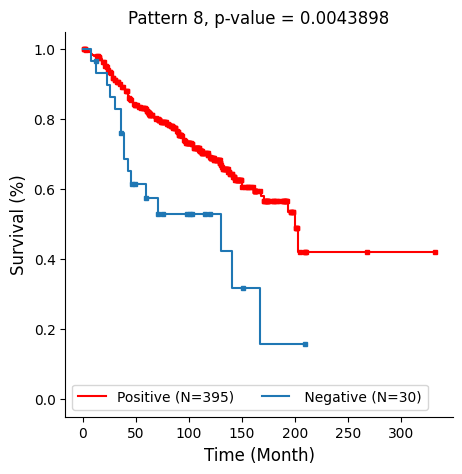

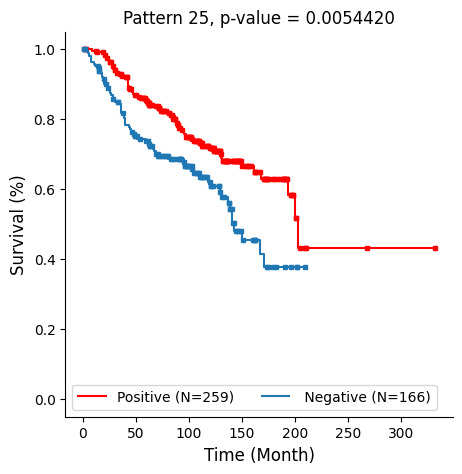

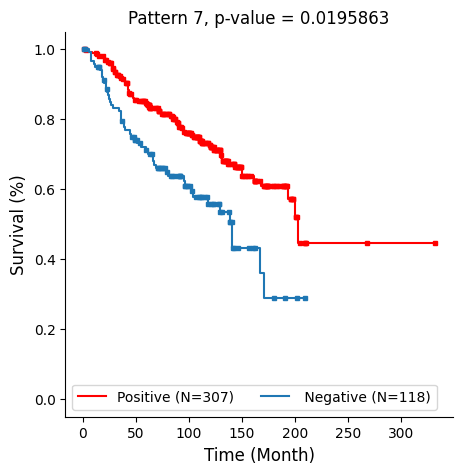

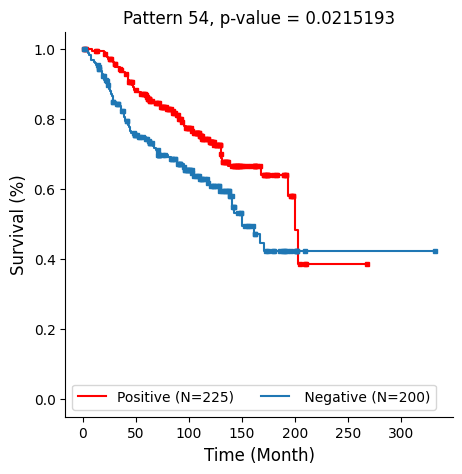

In [210]:
for pattern_id in Candidates:
    histogram_pattern = Histograms_[:, pattern_id]
    # print(
    #     "min = {}, max = {}, 25-percentile = {}, 50 percentile = {}, 90 percentile = {}".format(
    #         np.min(histogram_pattern),
    #         np.max(histogram_pattern),
    #         np.percentile(histogram_pattern, 25),
    #         np.percentile(histogram_pattern, 50),
    #         np.percentile(histogram_pattern, 90),
    #     )
    # )
    low_threshold = 0
    high_threshold = 0
    kmf = KaplanMeierFitter()
    length_A, event_observed_A = (
        Length_[histogram_pattern > 0],
        Status_[histogram_pattern > 0],
    )
    length_B, event_observed_B = (
        Length_[histogram_pattern == 0],
        Status_[histogram_pattern == 0],
    )
    # length_C, event_observed_C = (
    #     Length_[
    #         (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
    #     ],
    #     Status_[
    #         (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
    #     ],
    # )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B) ,
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    if p_value < 0.05/len(Candidates):
        f, ax = plt.subplots(figsize=(5, 5))
        kmf.fit(length_A, event_observed_A, label="Positive (N={})".format(len(length_A)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color="red",
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )

        kmf.fit(length_B, event_observed_B, label=" Negative (N={})".format(len(length_B)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color=color_palette[1],
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )
        # kmf.fit(length_C, event_observed_C, label="Low (N={})".format(len(length_C)))
        # kmf.plot_survival_function(
        #     ax=ax,
        #     ci_show=False,
        #     color=color_palette[3],
        #     show_censors=True,
        #     censor_styles={"ms": 3, "marker": "s"},
        # )
    ax.legend(ncol=2, fontsize=10)
    ax.set_title("Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12)
    ax.set_xlabel("Time (Month)", fontsize=12)
    ax.set_ylabel("Survival (%)", fontsize=12)
    ax.set(
            ylim=(-0.05, 1.05),
        )
    sns.despine()